In [1]:
import torch
from torch_geometric.data import HeteroData, DataLoader
import os
import torch.nn.functional as F
import networkx as nx
from collections import Counter

In [2]:
import json
# Load JSON file
with open('/home/quang.pham/3DSSG/similarity_fusion/data_json/train/cluster_data_id.json', 'r') as file:
    label_matching = json.load(file)

In [3]:
import torch
import torch.nn as nn

class SimilarityModel(nn.Module):
    def __init__(self, embed_dim=256, num_heads=8):
        super(SimilarityModel, self).__init__()
        # Define the linear layers
        self.edge_linear = nn.Linear(512, 256)
        self.represent_linear = nn.Linear(512, 256)
        
        # Define multi-head attention layer for node output vectors
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
        
    def forward(self, data_input):
        node_output_vectors = []

        # Process each node to compute its output vector
        for id in range(len(data_input)):
            node_vector = data_input[f"node_{id}"]["node_vector"]
            edge_vectors = data_input[f"node_{id}"]["edges"]
            node_vector = node_vector.to("cuda")
            
            edge_sum = torch.zeros(256).to("cuda")  # Initialize to match node vector size
            if edge_vectors != None:
                edge_vectors = edge_vectors.to("cuda")
                for edge in edge_vectors:
                    edge_sum += self.edge_linear(edge)

            # Concatenate the node vector and summed edge vector
            concatenated_vector = torch.cat((node_vector, edge_sum))  # Shape: (512,)
            
            # Pass the concatenated vector through the linear layer
            output_vector = self.represent_linear(concatenated_vector)  # Shape: (256,)
            node_output_vectors.append(output_vector.unsqueeze(0))  # Shape: (1, 256)
        
        # Stack all node output vectors into a single tensor
        node_output_tensor = torch.cat(node_output_vectors, dim=0)  # Shape: (num_nodes, 256)

        # Apply multi-head attention between the node output vectors
        # `attn_output` will have the same shape as `node_output_tensor` (num_nodes, 256)
        attn_output, _ = self.multihead_attn(node_output_tensor.unsqueeze(1),  # Query: (num_nodes, 1, 256)
                                             node_output_tensor.unsqueeze(1),  # Key: (num_nodes, 1, 256)
                                             node_output_tensor.unsqueeze(1))  # Value: (num_nodes, 1, 256)
        
        # Return the attention-weighted output for each node
        return attn_output.squeeze(1)  # Shape: (num_nodes, 256)


In [4]:
from __future__ import annotations

from typing import Iterable

import torch.nn.functional as F
from torch import Tensor, nn

from sentence_transformers.SentenceTransformer import SentenceTransformer
from sentence_transformers.losses import SiameseDistanceMetric
# from sentence_transformers.SentenceTransformer.ContrastiveLoss import SiameseDistanceMetric


class OnlineContrastiveLoss(nn.Module):
    def __init__(
        self, distance_metric=SiameseDistanceMetric.COSINE_DISTANCE, margin: float = 0.5
    ) -> None:
        """
        This Online Contrastive loss is similar to :class:`ConstrativeLoss`, but it selects hard positive (positives that
        are far apart) and hard negative pairs (negatives that are close) and computes the loss only for these pairs.
        This loss often yields better performances than ContrastiveLoss.

        Args:
            model: SentenceTransformer model
            distance_metric: Function that returns a distance between
                two embeddings. The class SiameseDistanceMetric contains
                pre-defined metrics that can be used
            margin: Negative samples (label == 0) should have a distance
                of at least the margin value.

        References:
            - `Training Examples > Quora Duplicate Questions <../../examples/training/quora_duplicate_questions/README.html>`_

        Requirements:
            1. (anchor, positive/negative) pairs
            2. Data should include hard positives and hard negatives

        Inputs:
            +-----------------------------------------------+------------------------------+
            | Texts                                         | Labels                       |
            +===============================================+==============================+
            | (anchor, positive/negative) pairs             | 1 if positive, 0 if negative |
            +-----------------------------------------------+------------------------------+

        Relations:
            - :class:`ContrastiveLoss` is similar, but does not use hard positive and hard negative pairs.
            :class:`OnlineContrastiveLoss` often yields better results.

        Example:
            ::

                from sentence_transformers import SentenceTransformer, SentenceTransformerTrainer, losses
                from datasets import Dataset

                model = SentenceTransformer("microsoft/mpnet-base")
                train_dataset = Dataset.from_dict({
                    "sentence1": ["It's nice weather outside today.", "He drove to work."],
                    "sentence2": ["It's so sunny.", "She walked to the store."],
                    "label": [1, 0],
                })
                loss = losses.OnlineContrastiveLoss(model)

                trainer = SentenceTransformerTrainer(
                    model=model,
                    train_dataset=train_dataset,
                    loss=loss,
                )
                trainer.train()
        """
        super().__init__()
        self.model = model
        self.margin = margin
        self.distance_metric = distance_metric

    # def forward(self, sentence_features: Iterable[dict[str, Tensor]], labels: Tensor, size_average=False) -> Tensor:
    def forward(self, embeddings, labels: Tensor, size_average=False) -> Tensor:
        # embeddings = [self.model(sentence_feature)["sentence_embedding"] for sentence_feature in sentence_features]


        distance_matrix = self.distance_metric(embeddings[0], embeddings[1])
        negs = distance_matrix[labels == 0]
        poss = distance_matrix[labels == 1]

        # select hard positive and hard negative pairs
        negative_pairs = negs[negs < (poss.max() if len(poss) > 1 else negs.mean())]
        positive_pairs = poss[poss > (negs.min() if len(negs) > 1 else poss.mean())]

        positive_loss = positive_pairs.pow(2).sum()
        negative_loss = F.relu(self.margin - negative_pairs).pow(2).sum()
        loss = positive_loss + negative_loss
        return loss

In [5]:
from __future__ import annotations

from typing import Any, Iterable

import torch
from torch import Tensor, nn

from sentence_transformers import util
from sentence_transformers.SentenceTransformer import SentenceTransformer


class MultipleNegativesRankingLoss(nn.Module):
    def __init__(self, model: SimilarityModel, scale: float = 20.0, similarity_fct=util.cos_sim) -> None:
        """
        This loss expects as input a batch consisting of sentence pairs ``(a_1, p_1), (a_2, p_2)..., (a_n, p_n)``
        where we assume that ``(a_i, p_i)`` are a positive pair and ``(a_i, p_j)`` for ``i != j`` a negative pair.

        For each ``a_i``, it uses all other ``p_j`` as negative samples, i.e., for ``a_i``, we have 1 positive example
        (``p_i``) and ``n-1`` negative examples (``p_j``). It then minimizes the negative log-likehood for softmax
        normalized scores.

        This loss function works great to train embeddings for retrieval setups where you have positive pairs
        (e.g. (query, relevant_doc)) as it will sample in each batch ``n-1`` negative docs randomly.

        The performance usually increases with increasing batch sizes.

        You can also provide one or multiple hard negatives per anchor-positive pair by structuring the data like this:
        ``(a_1, p_1, n_1), (a_2, p_2, n_2)``. Then, ``n_1`` is a hard negative for ``(a_1, p_1)``. The loss will use for
        the pair ``(a_i, p_i)`` all ``p_j`` for ``j != i`` and all ``n_j`` as negatives.

        Args:
            model: SentenceTransformer model
            scale: Output of similarity function is multiplied by scale
                value
            similarity_fct: similarity function between sentence
                embeddings. By default, cos_sim. Can also be set to dot
                product (and then set scale to 1)

        References:
            - Efficient Natural Language Response Suggestion for Smart Reply, Section 4.4: https://arxiv.org/pdf/1705.00652.pdf
            - `Training Examples > Natural Language Inference <../../examples/training/nli/README.html>`_
            - `Training Examples > Paraphrase Data <../../examples/training/paraphrases/README.html>`_
            - `Training Examples > Quora Duplicate Questions <../../examples/training/quora_duplicate_questions/README.html>`_
            - `Training Examples > MS MARCO <../../examples/training/ms_marco/README.html>`_
            - `Unsupervised Learning > SimCSE <../../examples/unsupervised_learning/SimCSE/README.html>`_
            - `Unsupervised Learning > GenQ <../../examples/unsupervised_learning/query_generation/README.html>`_

        Requirements:
            1. (anchor, positive) pairs or (anchor, positive, negative) triplets

        Inputs:
            +-------------------------------------------------+--------+
            | Texts                                           | Labels |
            +=================================================+========+
            | (anchor, positive) pairs                        | none   |
            +-------------------------------------------------+--------+
            | (anchor, positive, negative) triplets           | none   |
            +-------------------------------------------------+--------+
            | (anchor, positive, negative_1, ..., negative_n) | none   |
            +-------------------------------------------------+--------+

        Recommendations:
            - Use ``BatchSamplers.NO_DUPLICATES`` (:class:`docs <sentence_transformers.training_args.BatchSamplers>`) to
              ensure that no in-batch negatives are duplicates of the anchor or positive samples.

        Relations:
            - :class:`CachedMultipleNegativesRankingLoss` is equivalent to this loss, but it uses caching that allows for
              much higher batch sizes (and thus better performance) without extra memory usage. However, it is slightly
              slower.
            - :class:`MultipleNegativesSymmetricRankingLoss` is equivalent to this loss, but with an additional loss term.
            - :class:`GISTEmbedLoss` is equivalent to this loss, but uses a guide model to guide the in-batch negative
              sample selection. `GISTEmbedLoss` yields a stronger training signal at the cost of some training overhead.
        """
        super().__init__()
        self.model = model
        self.scale = scale
        self.similarity_fct = similarity_fct
        self.cross_entropy_loss = nn.CrossEntropyLoss()

    def forward(self, sentence_features: Iterable[dict[str, Tensor]], labels: Tensor) -> Tensor:
        reps = [self.model(sentence_feature)["sentence_embedding"] for sentence_feature in sentence_features]
        embeddings_a = reps[0]
        embeddings_b = torch.cat(reps[1:])

        scores = self.similarity_fct(embeddings_a, embeddings_b) * self.scale
        # Example a[i] should match with b[i]
        range_labels = torch.arange(0, scores.size(0), device=scores.device)
        return self.cross_entropy_loss(scores, range_labels)

    def get_config_dict(self) -> dict[str, Any]:
        return {"scale": self.scale, "similarity_fct": self.similarity_fct.__name__}


In [6]:
def generate_pairs(output_1, output_2, data_1_oid, data_2_oid):

    array_ne_1 = []
    array_ne_2 = []

    array_po_1 = []
    array_po_2 = []

    for i in range(len(output_1)):
        for j in range(len(output_2)):
            if data_1_oid[i] != data_2_oid[j]:
                array_ne_1.append(output_1[i].reshape(1, 256))
                array_ne_2.append(output_2[j].reshape(1, 256))
            else:
                array_po_1.append(output_1[i].reshape(1, 256))
                array_po_2.append(output_2[j].reshape(1, 256))
                # array_1.append(output_1[i])
                # array_2.append(output_1[j])

                # array_1.append(output_2[i])
                # array_2.append(output_2[j])

    tensor_ne_1 = torch.cat(array_ne_1, dim = 0)
    tensor_ne_2 = torch.cat(array_ne_2, dim = 0)

    tensor_po_1 = torch.cat(array_po_1, dim = 0)
    tensor_po_2 = torch.cat(array_po_2, dim = 0)

    negative_pair = torch.stack((tensor_ne_1, tensor_ne_2))
    labels_ne = torch.zeros(len(tensor_ne_1))

    possitive_pair = torch.stack((tensor_po_1, tensor_po_2))
    labels_po = torch.ones(len(tensor_po_1))

    labels = torch.cat((labels_po, labels_ne))
    embeddings = torch.cat((possitive_pair, negative_pair), dim = 1)

    # Shuffle the embeddings and labels
    permutation = torch.randperm(labels.size(0))
    shuffled_embeddings = embeddings[:, permutation]
    shuffled_labels = labels[permutation]

    return shuffled_embeddings, shuffled_labels


In [14]:
import random
from tqdm import tqdm


model = SimilarityModel()
model = model.to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
# Training loop
num_epochs = 1
loss_function = OnlineContrastiveLoss()
# mode = "train"
loss_function.to("cuda")

losses_total = []

similar_pairs = []
for ref in label_matching.keys():
    sequences = label_matching[ref]
    for i in range(len(sequences)):
        for j in range(i + 1, len(sequences)):
            similar_pairs.append([sequences[i], sequences[j]])

print("len similar pairs", len(similar_pairs))

labels_total = []
for epoch in tqdm(range(num_epochs)):
    random.shuffle(similar_pairs)
    loss_epoch = 0
    # for scan_id in label_matching.keys():
    len_node_pairs = 0
    for seq_ids in tqdm(similar_pairs):
        id_1, id_2= seq_ids
        data_1 = torch.load(f"/home/quang.pham/3DSSG/output_train/{id_1}/data.pt")
        data_filter_1 = torch.load(f"/home/quang.pham/3DSSG/output_train/{id_1}/data_filter.pt")

        data_2 = torch.load(f"/home/quang.pham/3DSSG/output_train/{id_2}/data.pt")
        data_filter_2 = torch.load(f"/home/quang.pham/3DSSG/output_train/{id_2}/data_filter.pt")
        # for data_input in data_loader:  # Assume you have a DataLoader for batching
        optimizer.zero_grad()

        # Forward pass for two sets of node data
        output_1 = model(data_filter_1["node_list"])
        output_2 = model(data_filter_2["node_list"])

        try:
            embeddings, labels = generate_pairs(output_1, output_2, data_1["node"].oid, data_2["node"].oid)
            len_node_pairs += len(labels)
            labels_total.extend(labels)
        except:
            # print("hehe")
            continue
        # Compute the contrastive loss with the cluster penalty
        loss = loss_function(embeddings, labels)
        loss_epoch += loss
        # 
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print("Number of node pairs for this sequence: {}".format(len_node_pairs))
    losses_total.append(loss_epoch/len(similar_pairs)) 
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")
    
    # Save the model every 10 epochs
    # if (epoch + 1) % 10 == 0:
    torch.save(model.state_dict(), f"temporal_model_epoch_{epoch+1}.pth")
    print(f"Model saved at epoch {epoch+1}")

len similar pairs 1275


100%|██████████| 1/1 [01:12<00:00, 72.96s/it]

Number of node pairs for this sequence: 321344
Epoch [1/1], Loss: 8.532654762268066
Model saved at epoch 1


In [18]:
labels_total1 = [i.tolist() for i in labels_total]
labels_total1

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [20]:
from collections import Counter
dict(Counter(labels_total1))

{0.0: 305183, 1.0: 16161}

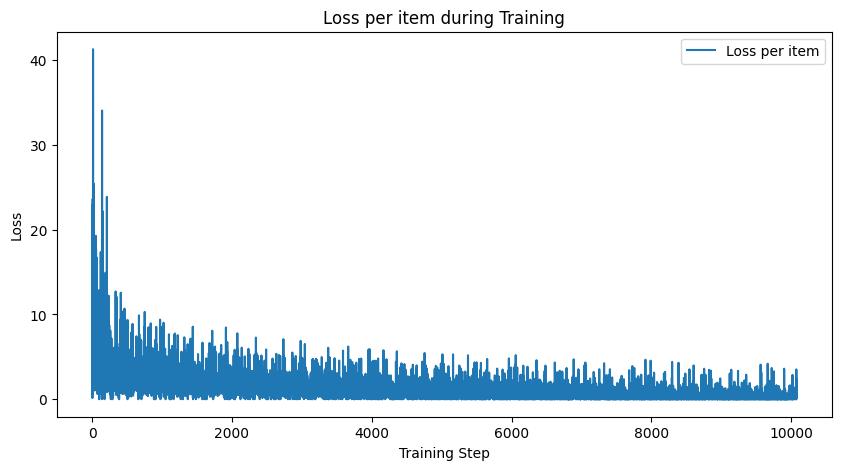

In [ ]:
import matplotlib.pyplot as plt
# Plotting the loss values
plt.figure(figsize=(10, 5))
plt.plot(losses_total, label="Loss per epoch")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Loss per Epoch during Training")
plt.legend()
plt.show()

Train

In [10]:
import json
# Load JSON file
with open('/home/quang.pham/3DSSG/similarity_fusion/data_json/train/cluster_data_id.json', 'r') as file:
    label_matching_test = json.load(file)

In [94]:
similar_pairs = []
for ref in label_matching_test.keys():
    sequences = label_matching_test[ref]
    for i in range(len(sequences)):
        for j in range(i + 1, len(sequences)):
            similar_pairs.append([sequences[i], sequences[j]])

In [96]:
# smaller_output
true_pred = 0
count = 0
total_commom = 0
for paris in similar_pairs:
    id_1, id_2 = paris
    data_1 = torch.load(f"/home/quang.pham/3DSSG/output_train/{id_1}/data.pt")
    data_filter_1 = torch.load(f"/home/quang.pham/3DSSG/output_train/{id_1}/data_filter.pt")

    data_2 = torch.load(f"/home/quang.pham/3DSSG/output_train/{id_2}/data.pt")
    data_filter_2 = torch.load(f"/home/quang.pham/3DSSG/output_train/{id_2}/data_filter.pt")

    output_1 = model(data_filter_1["node_list"])
    output_2 = model(data_filter_2["node_list"])

    smaller_seq, smaller_output = [data_1, output_1] if len(data_1["node"].oid) < len(data_2["node"].oid) else [data_2, output_2]
    bigger_seq, bigger_ouput = [data_2, output_2] if len(data_1["node"].oid) < len(data_2["node"].oid) else [data_1, output_1]

    common_elements = data_1["node"].oid[torch.isin(data_1["node"].oid, data_2["node"].oid)]

    # Count the number of common elements
    num_common_elements = len(common_elements)
    total_commom += num_common_elements
    for idx in range(len(smaller_output)):
        # print()
        a = cos_sim(output_1[idx].reshape(1, 256), output_2)
        b = torch.argmax(a).item()
        print(torch.max(a), data_2["node"].oid[b], data_1["node"].oid[idx])
        # if torch.max(a) < 0.5:
        #     if data_1["node"].oid[idx] not in data_2["node"].oid:
        #         true_pred += 1
        if data_2["node"].oid[b] == data_1["node"].oid[idx]:
            true_pred += 1
        count += 1

tensor(0.8872, device='cuda:0', grad_fn=<MaxBackward1>) tensor(33) tensor(33)
tensor(0.6888, device='cuda:0', grad_fn=<MaxBackward1>) tensor(35) tensor(35)
tensor(0.7523, device='cuda:0', grad_fn=<MaxBackward1>) tensor(8) tensor(8)
tensor(0.8358, device='cuda:0', grad_fn=<MaxBackward1>) tensor(9) tensor(9)
tensor(0.8748, device='cuda:0', grad_fn=<MaxBackward1>) tensor(16) tensor(16)
tensor(0.7622, device='cuda:0', grad_fn=<MaxBackward1>) tensor(17) tensor(17)
tensor(0.8762, device='cuda:0', grad_fn=<MaxBackward1>) tensor(18) tensor(18)
tensor(0.8139, device='cuda:0', grad_fn=<MaxBackward1>) tensor(19) tensor(19)
tensor(0.8351, device='cuda:0', grad_fn=<MaxBackward1>) tensor(21) tensor(21)
tensor(0.6578, device='cuda:0', grad_fn=<MaxBackward1>) tensor(22) tensor(22)
tensor(0.7797, device='cuda:0', grad_fn=<MaxBackward1>) tensor(28) tensor(28)
tensor(0.8689, device='cuda:0', grad_fn=<MaxBackward1>) tensor(29) tensor(29)
tensor(0.7989, device='cuda:0', grad_fn=<MaxBackward1>) tensor(30) t

In [97]:
true_pred/count

0.7453138946742041

In [98]:
true_pred/total_commom

0.7749180226443111

Test

In [9]:
from sentence_transformers.util import cos_sim, euclidean_sim

In [13]:
import glob
checkpoint_paths = glob.glob('./*.pth')
checkpoint_paths.sort(key=os.path.getmtime)
checkpoint_paths = checkpoint_paths[2:]
checkpoint_paths

['./temporal_model_epoch_1.pth',
 './temporal_model_epoch_2.pth',
 './temporal_model_epoch_3.pth',
 './temporal_model_epoch_4.pth',
 './temporal_model_epoch_5.pth',
 './temporal_model_epoch_6.pth',
 './temporal_model_epoch_7.pth',
 './temporal_model_epoch_8.pth',
 './temporal_model_epoch_9.pth',
 './temporal_model_epoch_10.pth',
 './temporal_model_epoch_11.pth',
 './temporal_model_epoch_12.pth']

In [7]:
import torch

# Re-initialize the model
model = SimilarityModel()
model = model.to("cuda")

# Load the saved checkpoint
checkpoint_path = "temporal_model_epoch_10_safe.pth"  # specify the path to your saved checkpoint
model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

In [8]:
import json
# Load JSON file
with open('/home/quang.pham/3DSSG/similarity_fusion/data_json/test/cluster_data_id.json', 'r') as file:
    label_matching_test = json.load(file)

In [9]:
cluster = []
for key in label_matching_test.keys():
    cluster.append(label_matching_test[key])

In [10]:
similar_pairs = []
for ref in label_matching_test.keys():
    sequences = label_matching_test[ref]
    for i in range(len(sequences)):
        for j in range(i + 1, len(sequences)):
            similar_pairs.append([sequences[i], sequences[j]])

In [11]:
from __future__ import annotations

import heapq
import logging
import os
from contextlib import nullcontext
from typing import TYPE_CHECKING, Callable

import numpy as np
import torch
from torch import Tensor
from tqdm import trange

from sentence_transformers.evaluation.SentenceEvaluator import SentenceEvaluator
from sentence_transformers.similarity_functions import SimilarityFunction

if TYPE_CHECKING:
    from sentence_transformers.SentenceTransformer import SentenceTransformer

logger = logging.getLogger(__name__)


class CustomInformationRetrievalEvaluator(SentenceEvaluator):

    def __init__(
        self,
        queries,  # qid => query
        corpus,  # cid => doc
        relevant_docs,  # qid => Set[cid]
        corpus_chunk_size: int = 50000,
        mrr_at_k: list[int] = [10],
        ndcg_at_k: list[int] = [10],
        accuracy_at_k: list[int] = [1, 3, 5, 10],
        precision_recall_at_k: list[int] = [1, 3, 5, 10],
        map_at_k: list[int] = [100],
        show_progress_bar: bool = False,
        batch_size: int = 32,
        name: str = "",
        write_csv: bool = True,
        truncate_dim: int | None = None,
        score_functions: dict[str, Callable[[Tensor, Tensor], Tensor]] | None = None,
        main_score_function: str | SimilarityFunction | None = None,
        query_prompt: str | None = None,
        query_prompt_name: str | None = None,
        corpus_prompt: str | None = None,
        corpus_prompt_name: str | None = None,
    ) -> None:
        """
        Initializes the InformationRetrievalEvaluator.

        Args:
            queries (Dict[str, str]): A dictionary mapping query IDs to queries.
            corpus (Dict[str, str]): A dictionary mapping document IDs to documents.
            relevant_docs (Dict[str, Set[str]]): A dictionary mapping query IDs to a set of relevant document IDs.
            corpus_chunk_size (int): The size of each chunk of the corpus. Defaults to 50000.
            mrr_at_k (List[int]): A list of integers representing the values of k for MRR calculation. Defaults to [10].
            ndcg_at_k (List[int]): A list of integers representing the values of k for NDCG calculation. Defaults to [10].
            accuracy_at_k (List[int]): A list of integers representing the values of k for accuracy calculation. Defaults to [1, 3, 5, 10].
            precision_recall_at_k (List[int]): A list of integers representing the values of k for precision and recall calculation. Defaults to [1, 3, 5, 10].
            map_at_k (List[int]): A list of integers representing the values of k for MAP calculation. Defaults to [100].
            show_progress_bar (bool): Whether to show a progress bar during evaluation. Defaults to False.
            batch_size (int): The batch size for evaluation. Defaults to 32.
            name (str): A name for the evaluation. Defaults to "".
            write_csv (bool): Whether to write the evaluation results to a CSV file. Defaults to True.
            truncate_dim (int, optional): The dimension to truncate the embeddings to. Defaults to None.
            score_functions (Dict[str, Callable[[Tensor, Tensor], Tensor]]): A dictionary mapping score function names to score functions. Defaults to the ``similarity`` function from the ``model``.
            main_score_function (Union[str, SimilarityFunction], optional): The main score function to use for evaluation. Defaults to None.
            query_prompt (str, optional): The prompt to be used when encoding the corpus. Defaults to None.
            query_prompt_name (str, optional): The name of the prompt to be used when encoding the corpus. Defaults to None.
            corpus_prompt (str, optional): The prompt to be used when encoding the corpus. Defaults to None.
            corpus_prompt_name (str, optional): The name of the prompt to be used when encoding the corpus. Defaults to None.
        """
        super().__init__()
        self.queries_ids = []
        for qid in queries:
            if qid in relevant_docs and len(relevant_docs[qid]) > 0:
                self.queries_ids.append(qid)

        self.queries = [queries[qid] for qid in self.queries_ids]

        self.corpus_ids = list(corpus.keys())
        self.corpus = [corpus[cid] for cid in self.corpus_ids]

        self.query_prompt = query_prompt
        self.query_prompt_name = query_prompt_name
        self.corpus_prompt = corpus_prompt
        self.corpus_prompt_name = corpus_prompt_name

        self.relevant_docs = relevant_docs
        self.corpus_chunk_size = corpus_chunk_size
        self.mrr_at_k = mrr_at_k
        self.ndcg_at_k = ndcg_at_k
        self.accuracy_at_k = accuracy_at_k
        self.precision_recall_at_k = precision_recall_at_k
        self.map_at_k = map_at_k

        self.show_progress_bar = show_progress_bar
        self.batch_size = batch_size
        self.name = name
        self.write_csv = write_csv
        self.score_functions = score_functions
        self.score_function_names = sorted(list(self.score_functions.keys())) if score_functions else []
        self.main_score_function = SimilarityFunction(main_score_function) if main_score_function else None
        self.truncate_dim = truncate_dim


    def __call__(
        self, model, output_path: str = None, epoch: int = -1, steps: int = -1, *args, **kwargs
    ) -> dict[str, float]:
        if epoch != -1:
            if steps == -1:
                out_txt = f" after epoch {epoch}"
            else:
                out_txt = f" in epoch {epoch} after {steps} steps"
        else:
            out_txt = ""
        if self.truncate_dim is not None:
            out_txt += f" (truncated to {self.truncate_dim})"

        logger.info(f"Information Retrieval Evaluation of the model on the {self.name} dataset{out_txt}:")


        scores = self.compute_metrices(model, *args, **kwargs)

        if not self.primary_metric:
            if self.main_score_function is None:
                score_function = max(
                    [(name, scores[name]["ndcg@k"][max(self.ndcg_at_k)]) for name in self.score_function_names],
                    key=lambda x: x[1],
                )[0]
                self.primary_metric = f"{score_function}_ndcg@{max(self.ndcg_at_k)}"
            else:
                self.primary_metric = f"{self.main_score_function.value}_ndcg@{max(self.ndcg_at_k)}"

        metrics = {
            f"{score_function}_{metric_name.replace('@k', '@' + str(k))}": value
            for score_function, values_dict in scores.items()
            for metric_name, values in values_dict.items()
            for k, value in values.items()
        }
        metrics = self.prefix_name_to_metrics(metrics, self.name)
        return metrics

    def compute_metrices(
        self, model, corpus_model=None
    ) -> dict[str, float]:
        if corpus_model is None:
            corpus_model = model

        query_embeddings=self.queries
        corpus_embeddings=self.corpus

        max_k = max(
            max(self.mrr_at_k),
            max(self.ndcg_at_k),
            max(self.accuracy_at_k),
            max(self.precision_recall_at_k),
            max(self.map_at_k),
        )

        queries_result_list = {}
        for name in self.score_functions:
            queries_result_list[name] = [[] for _ in range(len(query_embeddings))]

        # Iterate over chunks of the corpus
        for corpus_start_idx in trange(
            0, len(self.corpus), self.corpus_chunk_size, desc="Corpus Chunks", disable=not self.show_progress_bar
        ):
            corpus_end_idx = min(corpus_start_idx + self.corpus_chunk_size, len(self.corpus))
            sub_corpus_embeddings = corpus_embeddings[corpus_start_idx:corpus_end_idx]

            # Compute cosine similarites
            for name, score_function in self.score_functions.items():
                pair_scores = score_function(query_embeddings, sub_corpus_embeddings)

                # Get top-k values
                pair_scores_top_k_values, pair_scores_top_k_idx = torch.topk(
                    pair_scores, min(max_k, len(pair_scores[0])), dim=1, largest=True, sorted=False
                )
                pair_scores_top_k_values = pair_scores_top_k_values.cpu().tolist()
                pair_scores_top_k_idx = pair_scores_top_k_idx.cpu().tolist()

                for query_itr in range(len(query_embeddings)):
                    for sub_corpus_id, score in zip(
                        pair_scores_top_k_idx[query_itr], pair_scores_top_k_values[query_itr]
                    ):
                        corpus_id = self.corpus_ids[corpus_start_idx + sub_corpus_id]
                        # NOTE: TREC/BEIR/MTEB skips cases where the corpus_id is the same as the query_id, e.g.:
                        # if corpus_id == self.queries_ids[query_itr]:
                        #     continue
                        # This is not done here, as this might be unexpected behaviour if the user just uses
                        # sets of integers from 0 as query_ids and corpus_ids.
                        if len(queries_result_list[name][query_itr]) < max_k:
                            # heaqp tracks the quantity of the first element in the tuple
                            heapq.heappush(queries_result_list[name][query_itr], (score, corpus_id))
                        else:
                            heapq.heappushpop(queries_result_list[name][query_itr], (score, corpus_id))

        for name in queries_result_list:
            for query_itr in range(len(queries_result_list[name])):
                for doc_itr in range(len(queries_result_list[name][query_itr])):
                    score, corpus_id = queries_result_list[name][query_itr][doc_itr]
                    queries_result_list[name][query_itr][doc_itr] = {"corpus_id": corpus_id, "score": score}

        logger.info(f"Queries: {len(self.queries)}")
        logger.info(f"Corpus: {len(self.corpus)}\n")

        # Compute scores
        scores = {name: self.compute_metrics(queries_result_list[name]) for name in self.score_functions}

        # Output
        for name in self.score_function_names:
            logger.info(f"Score-Function: {name}")
            self.output_scores(scores[name])

        return scores

    def compute_metrics(self, queries_result_list: list[object]):
        # Init score computation values
        num_hits_at_k = {k: 0 for k in self.accuracy_at_k}
        precisions_at_k = {k: [] for k in self.precision_recall_at_k}
        recall_at_k = {k: [] for k in self.precision_recall_at_k}
        MRR = {k: 0 for k in self.mrr_at_k}
        ndcg = {k: [] for k in self.ndcg_at_k}
        AveP_at_k = {k: [] for k in self.map_at_k}

        # Compute scores on results
        for query_itr in range(len(queries_result_list)):
            query_id = self.queries_ids[query_itr]

            # Sort scores
            top_hits = sorted(queries_result_list[query_itr], key=lambda x: x["score"], reverse=True)
            query_relevant_docs = self.relevant_docs[query_id]

            # Accuracy@k - We count the result correct, if at least one relevant doc is across the top-k documents
            for k_val in self.accuracy_at_k:
                for hit in top_hits[0:k_val]:
                    if hit["corpus_id"] in query_relevant_docs:
                        num_hits_at_k[k_val] += 1
                        break

            # Precision and Recall@k
            for k_val in self.precision_recall_at_k:
                num_correct = 0
                for hit in top_hits[0:k_val]:
                    if hit["corpus_id"] in query_relevant_docs:
                        num_correct += 1

                precisions_at_k[k_val].append(num_correct / k_val)
                recall_at_k[k_val].append(num_correct / len(query_relevant_docs))

            # MRR@k
            for k_val in self.mrr_at_k:
                for rank, hit in enumerate(top_hits[0:k_val]):
                    if hit["corpus_id"] in query_relevant_docs:
                        MRR[k_val] += 1.0 / (rank + 1)
                        break

            # NDCG@k
            for k_val in self.ndcg_at_k:
                predicted_relevance = [
                    1 if top_hit["corpus_id"] in query_relevant_docs else 0 for top_hit in top_hits[0:k_val]
                ]
                true_relevances = [1] * len(query_relevant_docs)

                ndcg_value = self.compute_dcg_at_k(predicted_relevance, k_val) / self.compute_dcg_at_k(
                    true_relevances, k_val
                )
                ndcg[k_val].append(ndcg_value)

            # MAP@k
            for k_val in self.map_at_k:
                num_correct = 0
                sum_precisions = 0

                for rank, hit in enumerate(top_hits[0:k_val]):
                    if hit["corpus_id"] in query_relevant_docs:
                        num_correct += 1
                        sum_precisions += num_correct / (rank + 1)

                avg_precision = sum_precisions / min(k_val, len(query_relevant_docs))
                AveP_at_k[k_val].append(avg_precision)

        # Compute averages
        for k in num_hits_at_k:
            num_hits_at_k[k] /= len(self.queries)

        for k in precisions_at_k:
            precisions_at_k[k] = np.mean(precisions_at_k[k])

        for k in recall_at_k:
            recall_at_k[k] = np.mean(recall_at_k[k])

        for k in ndcg:
            ndcg[k] = np.mean(ndcg[k])

        for k in MRR:
            MRR[k] /= len(self.queries)

        for k in AveP_at_k:
            AveP_at_k[k] = np.mean(AveP_at_k[k])

        return {
            "accuracy@k": num_hits_at_k,
            "precision@k": precisions_at_k,
            "recall@k": recall_at_k,
            "ndcg@k": ndcg,
            "mrr@k": MRR,
            "map@k": AveP_at_k,
        }

    def output_scores(self, scores):
        for k in scores["accuracy@k"]:
            logger.info("Accuracy@{}: {:.2f}%".format(k, scores["accuracy@k"][k] * 100))

        for k in scores["precision@k"]:
            logger.info("Precision@{}: {:.2f}%".format(k, scores["precision@k"][k] * 100))

        for k in scores["recall@k"]:
            logger.info("Recall@{}: {:.2f}%".format(k, scores["recall@k"][k] * 100))

        for k in scores["mrr@k"]:
            logger.info("MRR@{}: {:.4f}".format(k, scores["mrr@k"][k]))

        for k in scores["ndcg@k"]:
            logger.info("NDCG@{}: {:.4f}".format(k, scores["ndcg@k"][k]))

        for k in scores["map@k"]:
            logger.info("MAP@{}: {:.4f}".format(k, scores["map@k"][k]))

    @staticmethod
    def compute_dcg_at_k(relevances, k):
        dcg = 0
        for i in range(min(len(relevances), k)):
            dcg += relevances[i] / np.log2(i + 2)  # +2 as we start our idx at 0
        return dcg

In [24]:
true_pred = 0
count = 0
total_common = 0
from tqdm import tqdm

final_results_dict = {}

for checkpoint_path in tqdm(checkpoint_paths):

    # Re-initialize the model
    model = SimilarityModel()
    model = model.to("cuda")

    # Load the saved checkpoint
    model.load_state_dict(torch.load(checkpoint_path))

    checkpoint_results = []

    for pair in tqdm(similar_pairs):
        id_1, id_2 = pair
        data_1 = torch.load(f"/home/quang.pham/3DSSG/output_test/{id_1}/data.pt")
        data_filter_1 = torch.load(f"/home/quang.pham/3DSSG/output_test/{id_1}/data_filter.pt")

        data_2 = torch.load(f"/home/quang.pham/3DSSG/output_test/{id_2}/data.pt")
        data_filter_2 = torch.load(f"/home/quang.pham/3DSSG/output_test/{id_2}/data_filter.pt")

        output_1 = model(data_filter_1["node_list"])
        output_2 = model(data_filter_2["node_list"])

        queries = {k:v for k,v in enumerate(output_1.tolist())}
        corpus = {k:v for k,v in enumerate(output_2.tolist())}
        relevant_docs = {}

        for query_id, query_oid in enumerate(data_1["node"].oid):
            if query_id not in relevant_docs:
                relevant_docs[query_id] = set()
            for corpus_id, corpus_oid in enumerate(data_2["node"].oid):
                if query_oid == corpus_oid:
                    relevant_docs[query_id].add(corpus_id)

        ir_evaluator = CustomInformationRetrievalEvaluator(
            queries = queries,  # qid => query
            corpus = corpus,  # cid => doc
            relevant_docs = relevant_docs,  # qid => Set[cid]
            mrr_at_k  = [1, 3, 5, 10],
            ndcg_at_k = [1, 3, 5, 10],
            accuracy_at_k = [1, 3, 5, 10],
            precision_recall_at_k = [1, 3, 5, 10],
            map_at_k = [1, 10, 100],
            show_progress_bar = False,
            batch_size = 32,
            score_functions = {"cos_sim": util.cos_sim},
        )

        results = ir_evaluator(model)
        checkpoint_results.append(results)

    checkpoint_results_dict = {}
    for results in checkpoint_results:
        for metric_name, v in results.items():
            if metric_name not in checkpoint_results_dict:
                checkpoint_results_dict[metric_name] = []
            checkpoint_results_dict[metric_name].append(v)

    for metric_name, v in checkpoint_results_dict.items():
        #print(f"{metric_name}: {sum(v) / len(v)}")
        if metric_name not in final_results_dict:
            final_results_dict[metric_name] = []
        final_results_dict[metric_name].append(sum(v) / len(v))

100%|██████████| 12/12 [01:42<00:00,  8.53s/it]


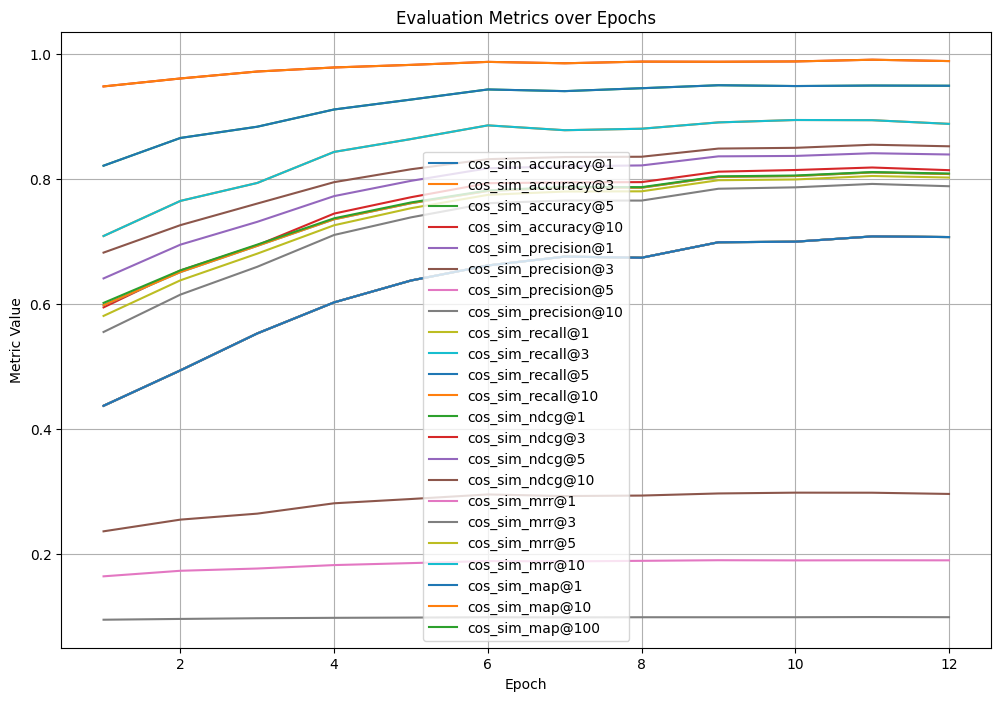

In [41]:
epochs = range(1, 13)

# Plot each metric as a separate line
plt.figure(figsize=(12, 8))
for metric, values in final_results_dict.items():
    plt.plot(epochs, values, label=metric)

# Adding labels, title, and legend
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Evaluation Metrics over Epochs')
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.show()

In [19]:
# id_1, id_2 = similar_pairs[0]
# data_1 = torch.load(f"/home/quang.pham/3DSSG/output_test/{id_1}/data.pt")
# data_filter_1 = torch.load(f"/home/quang.pham/3DSSG/output_test/{id_1}/data_filter.pt")

# data_2 = torch.load(f"/home/quang.pham/3DSSG/output_test/{id_2}/data.pt")
# data_filter_2 = torch.load(f"/home/quang.pham/3DSSG/output_test/{id_2}/data_filter.pt")

# data_1["node"].oid

In [12]:
true_pred = 0
count = 0
total_common = 0
from tqdm import tqdm

final_results = []

for pair in tqdm(similar_pairs):
    id_1, id_2 = pair
    data_1 = torch.load(f"/home/quang.pham/3DSSG/output_test/{id_1}/data.pt")
    data_filter_1 = torch.load(f"/home/quang.pham/3DSSG/output_test/{id_1}/data_filter.pt")

    data_2 = torch.load(f"/home/quang.pham/3DSSG/output_test/{id_2}/data.pt")
    data_filter_2 = torch.load(f"/home/quang.pham/3DSSG/output_test/{id_2}/data_filter.pt")

    output_1 = model(data_filter_1["node_list"])
    output_2 = model(data_filter_2["node_list"])

    queries = {k:v for k,v in enumerate(output_1.tolist())}
    corpus = {k:v for k,v in enumerate(output_2.tolist())}
    relevant_docs = {}

    for query_id, query_oid in enumerate(data_1["node"].oid):
        if query_id not in relevant_docs:
            relevant_docs[query_id] = set()
        for corpus_id, corpus_oid in enumerate(data_2["node"].oid):
            if query_oid == corpus_oid:
                relevant_docs[query_id].add(corpus_id)

    ir_evaluator = CustomInformationRetrievalEvaluator(
        queries = queries,  # qid => query
        corpus = corpus,  # cid => doc
        relevant_docs = relevant_docs,  # qid => Set[cid]
        mrr_at_k  = [1,2, 3, 5, 10],
        ndcg_at_k = [1, 2, 3, 5, 10],
        accuracy_at_k = [1, 2, 3, 5, 10],
        precision_recall_at_k = [1, 2, 3, 5, 10],
        map_at_k = [1,2, 3, 5, 10, 100],
        show_progress_bar = False,
        batch_size = 32,
        score_functions = {"cos_sim": util.cos_sim},
    )

    results = ir_evaluator(model)
    final_results.append(results)

100%|██████████| 269/269 [00:10<00:00, 26.38it/s]


# RESULTS

In [13]:
final_results_dict = {}
for results in final_results:
    for metric_name, v in results.items():
        if metric_name not in final_results_dict:
            final_results_dict[metric_name] = []
        final_results_dict[metric_name].append(v)

    

for metric_name, v in final_results_dict.items():
    print(f"{metric_name}: {sum(v) / len(v)}")

cos_sim_accuracy@1: 0.7014845289666217
cos_sim_accuracy@2: 0.8406164489626943
cos_sim_accuracy@3: 0.9009081995619386
cos_sim_accuracy@5: 0.9525218834488595
cos_sim_accuracy@10: 0.9925261830460416
cos_sim_precision@1: 0.7014845289666217
cos_sim_precision@2: 0.42030822448134714
cos_sim_precision@3: 0.300302733187313
cos_sim_precision@5: 0.19050437668977235
cos_sim_precision@10: 0.0992526183046045
cos_sim_recall@1: 0.7014845289666217
cos_sim_recall@2: 0.8406164489626943
cos_sim_recall@3: 0.9009081995619386
cos_sim_recall@5: 0.9525218834488595
cos_sim_recall@10: 0.9925261830460416
cos_sim_ndcg@1: 0.7014845289666217
cos_sim_ndcg@2: 0.7892669969636681
cos_sim_ndcg@3: 0.8194128722632903
cos_sim_ndcg@5: 0.8409004223435449
cos_sim_ndcg@10: 0.8541847918852722
cos_sim_mrr@1: 0.7014845289666217
cos_sim_mrr@2: 0.7710504889646581
cos_sim_mrr@3: 0.7911477391644062
cos_sim_mrr@5: 0.8032054387733331
cos_sim_mrr@10: 0.8088914077497571
cos_sim_map@1: 0.7014845289666217
cos_sim_map@2: 0.7710504889646581
c

In [55]:
top_k = 3  # Define the top K value for similarity matching
true_pred = 0
count = 0
total_common = 0

for pair in tqdm(similar_pairs):
    id_1, id_2 = pair
    data_1 = torch.load(f"/home/quang.pham/3DSSG/output_test/{id_1}/data.pt")
    data_filter_1 = torch.load(f"/home/quang.pham/3DSSG/output_test/{id_1}/data_filter.pt")

    data_2 = torch.load(f"/home/quang.pham/3DSSG/output_test/{id_2}/data.pt")
    data_filter_2 = torch.load(f"/home/quang.pham/3DSSG/output_test/{id_2}/data_filter.pt")

    output_1 = model(data_filter_1["node_list"])
    output_2 = model(data_filter_2["node_list"])

    # Determine the smaller and bigger sequences based on the length of `oid` nodes
    if len(data_1["node"].oid) < len(data_2["node"].oid):
        smaller_seq, smaller_output = data_1, output_1
        bigger_seq, bigger_output = data_2, output_2
    else:
        smaller_seq, smaller_output = data_2, output_2
        bigger_seq, bigger_output = data_1, output_1

    # Find common elements between the two sequences
    common_elements = smaller_seq["node"].oid[torch.isin(smaller_seq["node"].oid, bigger_seq["node"].oid)]
    num_common_elements = len(common_elements)
    total_common += num_common_elements

    # # Iterate over each element in `smaller_output`
    for idx in range(len(smaller_output)):
        # Calculate cosine similarity between the current element in smaller_output and all elements in bigger_output
        similarities = cos_sim(smaller_output[idx].reshape(1, 256), bigger_output)
        
        # Find the top K indices with the highest similarity scores
        top_k_indices = torch.topk(similarities, k=top_k).indices.squeeze().tolist()
        if type(top_k_indices) == int:
            top_k_indices = [top_k_indices, ]
        # Check if any of the top K matched elements is a true match
        matched = False
        for b_idx in top_k_indices:
            if bigger_seq["node"].oid[b_idx] == smaller_seq["node"].oid[idx]:
                matched = True
                break
        
        # Update `true_pred` based on whether a match was found
        if matched and torch.max(similarities) >= 0.5:
            true_pred += 1
        elif smaller_seq["node"].oid[idx] not in bigger_seq["node"].oid:
            true_pred += 1
        
        count += 1

100%|██████████| 269/269 [00:08<00:00, 32.39it/s]


In [56]:
true_pred/count

0.8533412182140745

In [57]:
true_pred/total_common

0.942829140803659

Localization

In [72]:
total_sequences = []
for i in cluster:
    if len(i) != 1:
        total_sequences += i
        

In [77]:
from tqdm import tqdm

In [86]:
result_matching = []
for id_seq_1 in tqdm(range(len(total_sequences))):
    max = 0
    matching_seq = []
    for id_seq_2 in range(id_seq_1, len(total_sequences)):
        id_1, id_2 = total_sequences[id_seq_1], total_sequences[id_seq_2]

        data_1 = torch.load(f"/home/quang.pham/3DSSG/output_test/{id_1}/data.pt")
        data_filter_1 = torch.load(f"/home/quang.pham/3DSSG/output_test/{id_1}/data_filter.pt")

        data_2 = torch.load(f"/home/quang.pham/3DSSG/output_test/{id_2}/data.pt")
        data_filter_2 = torch.load(f"/home/quang.pham/3DSSG/output_test/{id_2}/data_filter.pt")

        output_1 = model(data_filter_1["node_list"])
        output_2 = model(data_filter_2["node_list"])

        count = 0
        if len(data_1["node"].oid) < len(data_2["node"].oid):
            smaller_seq, smaller_output = data_1, output_1
            bigger_seq, bigger_output = data_2, output_2
        else:
            smaller_seq, smaller_output = data_2, output_2
            bigger_seq, bigger_output = data_1, output_1

        # Iterate over each element in `smaller_output`
        for idx in range(len(smaller_output)):
            # Calculate cosine similarity between the current element in smaller_output and all elements in bigger_output
            similarities = cos_sim(smaller_output[idx].reshape(1, 256), bigger_output)
            conf_score = torch.max(similarities)

            if conf_score > 0.5:
                count += 1
            
        if count > max:
            matching_seq = [id_1, id_2]
    
    result_matching.append(matching_seq)

100%|██████████| 157/157 [09:49<00:00,  3.76s/it]


In [84]:
len(result_matching)

157

In [88]:
result_matching

[['4fbad32f-465b-2a5d-8408-146ab1d72808',
  '321c867e-a5a8-2a84-851a-818df115be05'],
 ['4fbad31e-465b-2a5d-84b7-c0ddea978db4',
  '321c867e-a5a8-2a84-851a-818df115be05'],
 ['9af05c68-5794-2e19-8c5a-979f448da545',
  '321c867e-a5a8-2a84-851a-818df115be05'],
 ['4fbad331-465b-2a5d-8488-852fcda9513c',
  '321c867e-a5a8-2a84-851a-818df115be05'],
 ['6bde607d-9162-246f-8f84-98cf7ac2374c',
  '321c867e-a5a8-2a84-851a-818df115be05'],
 ['6bde607b-9162-246f-8e65-76e3ef265504',
  '321c867e-a5a8-2a84-851a-818df115be05'],
 ['6bde6081-9162-246f-8c4e-ffaf709d17b1',
  '321c867e-a5a8-2a84-851a-818df115be05'],
 ['6bde6083-9162-246f-8c9c-e170212059b2',
  '321c867e-a5a8-2a84-851a-818df115be05'],
 ['0cac75dc-8d6f-2d13-8d08-9c497bd6acdc',
  '5630cfde-12bf-2860-8563-d68bdd98fab0'],
 ['0cac75de-8d6f-2d13-8e1a-b574569c3885',
  'c92fb5b5-f771-2064-8570-dbe16cb33764'],
 ['41385849-a238-2435-81d0-ceb0eba4541a',
  '5630cfde-12bf-2860-8563-d68bdd98fab0'],
 ['8eabc45f-5af7-2f32-8528-640861d2a135',
  '5630cfde-12bf-2860-8

In [87]:
for i in result_matching:
    seq_1_rel, seq_2_rel = i
    for cluster_seq in cluster:
        if seq_1_rel in cluster_seq and seq_2_rel in cluster_seq:
            print("he")

he
he
he
he
he
he
he
he


Linh tinh

In [12]:
id_1, id_2 = similar_pairs[0]
data_1 = torch.load(f"/home/quang.pham/3DSSG/output_test/{id_1}/data.pt")
data_filter_1 = torch.load(f"/home/quang.pham/3DSSG/output_test/{id_1}/data_filter.pt")

data_2 = torch.load(f"/home/quang.pham/3DSSG/output_test/{id_2}/data.pt")
data_filter_2 = torch.load(f"/home/quang.pham/3DSSG/output_test/{id_2}/data_filter.pt")

In [53]:
smaller_seq["node"].oid

tensor([ 1,  3,  8,  9, 19, 20, 14, 17, 22, 10,  2, 18, 30, 15, 21,  7])

In [15]:
data_1["node"].oid

tensor([ 1,  3,  8,  9, 19, 20, 14, 17, 22, 10,  2, 18, 30, 15, 21,  7])

In [16]:
data_2["node"].oid

tensor([ 1,  3, 10, 17, 19, 20, 22,  2, 18, 52,  9, 30, 13, 14, 33, 21, 15,  7,
         8])

In [17]:
output_1 = model(data_filter_1["node_list"])
output_2 = model(data_filter_2["node_list"])

In [67]:
smaller_seq, smaller_output = [data_1, output_1] if len(data_1["node"].oid) < len(data_2["node"].oid) else [data_2, output_2]
bigger_seq, bigger_ouput = [data_2, output_2] if len(data_1["node"].oid) < len(data_2["node"].oid) else [data_1, output_1]

# smaller_output
true_pred = 0
count = 0
for idx in range(len(smaller_output)):
    # print()
    a = cos_sim(output_1[idx].reshape(1, 256), output_2)
    b = torch.argmax(a).item()
    print(torch.max(a), data_2["node"].oid[b], data_1["node"].oid[idx])
    if data_2["node"].oid[b] == data_1["node"].oid[idx]:
        true_pred += 1
    count += 1

tensor(0.7331, device='cuda:0', grad_fn=<MaxBackward1>) tensor(1) tensor(1)
tensor(0.8125, device='cuda:0', grad_fn=<MaxBackward1>) tensor(3) tensor(3)
tensor(0.7782, device='cuda:0', grad_fn=<MaxBackward1>) tensor(8) tensor(8)
tensor(0.8056, device='cuda:0', grad_fn=<MaxBackward1>) tensor(9) tensor(9)
tensor(0.7372, device='cuda:0', grad_fn=<MaxBackward1>) tensor(19) tensor(19)
tensor(0.8993, device='cuda:0', grad_fn=<MaxBackward1>) tensor(20) tensor(20)
tensor(0.8503, device='cuda:0', grad_fn=<MaxBackward1>) tensor(13) tensor(14)
tensor(0.8556, device='cuda:0', grad_fn=<MaxBackward1>) tensor(17) tensor(17)
tensor(0.9345, device='cuda:0', grad_fn=<MaxBackward1>) tensor(30) tensor(22)
tensor(0.8878, device='cuda:0', grad_fn=<MaxBackward1>) tensor(10) tensor(10)
tensor(0.9218, device='cuda:0', grad_fn=<MaxBackward1>) tensor(2) tensor(2)
tensor(0.8973, device='cuda:0', grad_fn=<MaxBackward1>) tensor(21) tensor(18)
tensor(0.8451, device='cuda:0', grad_fn=<MaxBackward1>) tensor(30) tensor(

[['4fbad32f-465b-2a5d-8408-146ab1d72808',
  '4fbad31e-465b-2a5d-84b7-c0ddea978db4'],
 ['4fbad32f-465b-2a5d-8408-146ab1d72808',
  '9af05c68-5794-2e19-8c5a-979f448da545'],
 ['4fbad32f-465b-2a5d-8408-146ab1d72808',
  '4fbad331-465b-2a5d-8488-852fcda9513c'],
 ['4fbad31e-465b-2a5d-84b7-c0ddea978db4',
  '9af05c68-5794-2e19-8c5a-979f448da545'],
 ['4fbad31e-465b-2a5d-84b7-c0ddea978db4',
  '4fbad331-465b-2a5d-8488-852fcda9513c'],
 ['9af05c68-5794-2e19-8c5a-979f448da545',
  '4fbad331-465b-2a5d-8488-852fcda9513c'],
 ['6bde607d-9162-246f-8f84-98cf7ac2374c',
  '6bde607b-9162-246f-8e65-76e3ef265504'],
 ['6bde607d-9162-246f-8f84-98cf7ac2374c',
  '6bde6081-9162-246f-8c4e-ffaf709d17b1'],
 ['6bde607d-9162-246f-8f84-98cf7ac2374c',
  '6bde6083-9162-246f-8c9c-e170212059b2'],
 ['6bde607b-9162-246f-8e65-76e3ef265504',
  '6bde6081-9162-246f-8c4e-ffaf709d17b1'],
 ['6bde607b-9162-246f-8e65-76e3ef265504',
  '6bde6083-9162-246f-8c9c-e170212059b2'],
 ['6bde6081-9162-246f-8c4e-ffaf709d17b1',
  '6bde6083-9162-246f-8

In [ ]:
# output_1 = model(data_filter_1["node_list"])
# output_2 = model(data_filter_2["node_list"])
# joint_nodes = torch.cat((output_1,output_2), 0).detach().numpy()

# clustering = DBSCAN(eps=3, min_samples=2).fit(joint_nodes)
# labels = clustering.labels_
# generate_node_pairs(joint_nodes, labels)
# labels